In [1]:
#!/usr/bin/env python3

# Authored by Gary Lvov and Nathaniel Hanson

from calendar import c
from lib2to3.pgen2.tokenize import TokenError
from anyio import start_blocking_portal
import numpy as np
import math
import threading
import rospy
import rospkg
import cv2 as cv
from typing import List, Tuple
from matplotlib import pyplot as plt
from cv_bridge import CvBridge
from sensor_msgs.msg import Image
from cluttered_grasp.srv import segment_plane, roi, roiResponse
from cluttered_grasp.srv import nudge, nudgeResponse
from spectral_finger_planner.srv import Move
from spectral_finger_planner.srv import Grasp
from geometry_msgs.msg import Point
from copy import deepcopy

class ClutterNudge:
    def __init__(self):
        rospy.init_node("hacker")
        self.NUM_WAVELENGTHS = 273
        self.br = CvBridge()
        self.lock = threading.RLock()
        # Subscribe to average depth image
        depth_image_sub = rospy.Subscriber('/depth_to_rgb/image_raw', Image, self._image_callback)
        self.pkg_path = rospkg.RosPack().get_path("cluttered_grasp")
        rospy.wait_for_service('ur3e_move_point')
        self.move_arm = rospy.ServiceProxy('ur3e_move_point', Move)
        rospy.wait_for_service('gripper_control')
        self.gripper_manip = rospy.ServiceProxy('gripper_control', Grasp)
        self.MAX_ANOMALIES = rospy.get_param('~max_anom', 10)
        self.HOME = [-0.25,-0.10,0.45]
        self.BBX = [0, 2000]
        self.BBY = [0, 2000] #TODO: choose dimensions of image
        self.PRIMITIVES_RADIUS_SIZE = 100
        self.PRIMITIVES_ANGLE_VAR = .314
        self.GRIPPER_OFFSET = 0.20
        self.GRIPPER_X_OFFSET = -0.09
        self.GRIPPER_Y_OFFSET = 0#-0.092
        self.CLUTTER_COL_TOL = 3 # millimeters
        self.CLUTTER_COL_WINDOW_SIZE = 50 #pixels
        self.CLUTTER_COL_STEP_SIZE = 1
        self.prep_move_arm(self.HOME)
        print("Node Initialized succesfully")

    def prep_move_arm(self, position: List) -> bool:
        '''
        Move arm to requested x,y,z point
        # '''
        toSendMeta = Move()
        toSend = Point()
        toSend.x = np.round(position[0],4)
        toSend.y = np.round(position[1],4)
        toSend.z = np.round(position[2],4)
        toSendMeta.request = toSend
        response = self.move_arm(toSend)
        return response

    def convert_plan(self, plan):
        newPlan = []
        depth = max(self.current_img[int(plan[0][0]), int(plan[0][1])], self.current_img[int(plan[1][0]), int(plan[1][1])])

        for x in range(2):
            newPlan.append(self.convert_depth_pixel_to_metric_coordinate(depth, plan[x][0], plan[x][1]))

        return newPlan

    def convert_depth_pixel_to_metric_coordinate(self, pixel_x=0, pixel_y=0, depth=0):
        """
        Convert the depth and image point information to metric coordinates
        Parameters:
        -----------
        depth 	 	 	 : double
                                The depth value of the image point
        pixel_x 	  	 	 : double
                                The x value of the image coordinate
        pixel_y 	  	 	 : double
                                The y value of the image coordinate
        Return:
        ----------
        X : double
            The x value in meters
        Y : double
            The y value in meters
        Z : double
            The z value in meters
        """
        X = (pixel_x - 1028.62)/972.764 *depth/1000
        Y = (pixel_y - 776.698)/972.484 *depth/1000
        return [X, Y, depth/1000]

    def generate_candidate_plans(self, point: Point) -> np.ndarray:
        '''
        Given a point in R^3, heuristically generate candidate points that pass
        through the region

        returns: np.ndarray containing start and end points 
        [
            [
                [x1,y1], [x1',y1']
            ],[
                [x2,y2], [x2',y2']
            ],[
                [x3,y3], [x3',y3']
            ]
        ]
        '''
        img = self.current_img
        plt.gcf()
        plt.imshow(img)
        if (point.x - self.PRIMITIVES_RADIUS_SIZE < self.BBX[0] or
            point.x + self.PRIMITIVES_RADIUS_SIZE > self.BBX[1] or
            point.y - self.PRIMITIVES_RADIUS_SIZE < self.BBY[0] or
            point.y + self.PRIMITIVES_RADIUS_SIZE > self.BBY[1]):
            raise ValueError(f"{point.x} or {point.y} is outside of bounding boxes {self.BBX} or {self.BBY}")
        else:
            potential_moves = []
            for angle in range(1, 11):
                x_offset = int(self.PRIMITIVES_RADIUS_SIZE * math.sin(angle * self.PRIMITIVES_ANGLE_VAR))
                y_offset = int(self.PRIMITIVES_RADIUS_SIZE * math.cos(angle * self.PRIMITIVES_ANGLE_VAR))
                # cast to int as pixels cannot be floats
                move = [[point.x - x_offset, point.y - y_offset, img[int(point.x - x_offset),int(point.y - y_offset)]], 
                        [point.x + x_offset, point.y + y_offset, img[int(point.x + x_offset),int(point.y + y_offset)]]]
                plt.plot(point.x - x_offset, point.y - y_offset, 'ro', color="blue", markersize=1)
                plt.plot(point.x + x_offset, point.y + y_offset, 'ro', color="red", markersize=1)
                potential_moves.append(move)
                plt.draw()
        return potential_moves

    def execute_plan(self, plan: np.ndarray) -> bool:
        '''
        Move the arm from the start/end position of the gripper using PyKDL and the move point service
        '''
        # Move arm to start position
        self.gripper_manip('close')
        # TAKE HOME POSITION
        for x in range(5):
            newTargetZ = np.clip(self.HOME[2] - plan[0][2] + self.GRIPPER_OFFSET,-0.5,0.5)
            # Calculate flipped x and y positions        self.HOME = [-0.25,-0.10,0.45]
            newTargetX = np.clip(plan[0][1] + self.HOME[0] + self.GRIPPER_X_OFFSET,-0.45,-0.1)
            newTargetY = np.clip(plan[0][0] + self.HOME[1] + self.GRIPPER_Y_OFFSET,-0.45,0.45)
            print(f'Moving arm to: {[newTargetX, newTargetY, newTargetZ+0.1]}')
            #elf.prep_move_arm([newTargetX, newTargetY, newTargetZ+0.1])

        # Lower arm into positions
        self.prep_move_arm([newTargetX, newTargetY, newTargetZ])
        # Move across surface area
        for _ in range(5):
            newTargetX = np.clip(plan[1][1] + self.HOME[0] + self.GRIPPER_X_OFFSET,-0.4,-0.1)
            newTargetY = np.clip(plan[1][0] + self.HOME[1] + self.GRIPPER_Y_OFFSET,-0.4,0.4)
            newTargetZ = np.clip(self.HOME[2] - plan[1][2] + self.GRIPPER_OFFSET,-0.5,0.5)
            print(f'Moving arm to: {[newTargetX, newTargetY, newTargetZ+0.1]}')
            #elf.prep_move_arm([newTargetX, newTargetY, newTargetZ])

        # Move arm to ready position
        for _ in range(5):
            # Return to the original position
            newTargetZ = np.clip(self.HOME[2] - plan[0][2] + self.GRIPPER_OFFSET,-0.5,0.5)
            # Calculate flipped x and y positions        self.HOME = [-0.25,-0.10,0.45]
            newTargetX = np.clip(plan[0][1] + self.HOME[0] + self.GRIPPER_X_OFFSET,-0.4,-0.1)
            newTargetY = np.clip(plan[0][0] + self.HOME[1] + self.GRIPPER_Y_OFFSET,-0.4,0.4)
            #self.prep_move_arm([newTargetX, newTargetY, newTargetZ])
            print(f'Moving arm to: {[newTargetX, newTargetY, newTargetZ+0.1]}')

        #self.prep_move_arm([newTargetX, newTargetY, newTargetZ+0.1])
        # Move arm home
        #self.prep_move_arm(self.HOME)
        self.gripper_manip('open')

    def _image_callback(self, msg):
        with self.lock:
            self.current_img = self.br.imgmsg_to_cv2(msg)
            
    def get_depth(self,x,y,img=[]):
        ### This needs the x and y to be flipped
        y,x = x,y
        #with self.lock:
        if len(img) > 0:
            return img[x,y]
        return self.current_img[x,y]

In [2]:
c = ClutterNudge()

Node Initialized succesfully


In [ ]:
# POINT HAS TO BE PROVIDED IN IMAGE SPACE
def generate_candidate_plans(point: Point) -> np.ndarray:
        img = c.current_img
        START_OFFSET = 0.1
        PRIMITIVES_ANGLE_VAR = .314
        PRIMITIVES_RADIUS_SIZE = 50
        plt.figure()
        '''
        Given a point in R^3, heuristically generate candidate points that pass
        through the region

        returns: np.ndarray containing start and end points 
        [
            [
                [x1,y1], [x1',y1']
            ],[
                [x2,y2], [x2',y2']
            ],[
                [x3,y3], [x3',y3']
            ]
        ]
        '''
        

        plt.gcf()

        potential_moves = []
        plt.imshow(img)
        plt.plot(point.y, point.x, 'ro', color="pink", markersize=3)
        plt.text(point.y, point.x, "X's and Y's swapped")
        
        plt.plot(point.x, point.y, 'ro', color="purple", markersize=3)
        plt.text(point.x, point.y, "X's and Y's in positions provided")
        
        for angle in range(1, 11):
            x_offset = int(PRIMITIVES_RADIUS_SIZE * math.sin(START_OFFSET + angle * PRIMITIVES_ANGLE_VAR))
            y_offset = int(PRIMITIVES_RADIUS_SIZE * math.cos(START_OFFSET + angle * PRIMITIVES_ANGLE_VAR))
            # cast to int as pixels cannot be floats
            move = [[point.x - x_offset, point.y - y_offset, c.get_depth(point.x - x_offset, point.y - y_offset)], 
                    [point.x + x_offset, point.y + y_offset, c.get_depth(point.x + x_offset, point.y + y_offset)]]

            # Visualization has x and y's swapped
            plt.plot(point.x - x_offset, point.y - y_offset, 'ro', color="blue", markersize=1)
            plt.plot( point.x + x_offset, point.y + y_offset, 'ro', color="red", markersize=1)


            potential_moves.append(move)
            plt.draw()
        plt.show()
        return potential_moves
    

<IPython.core.display.Javascript object>


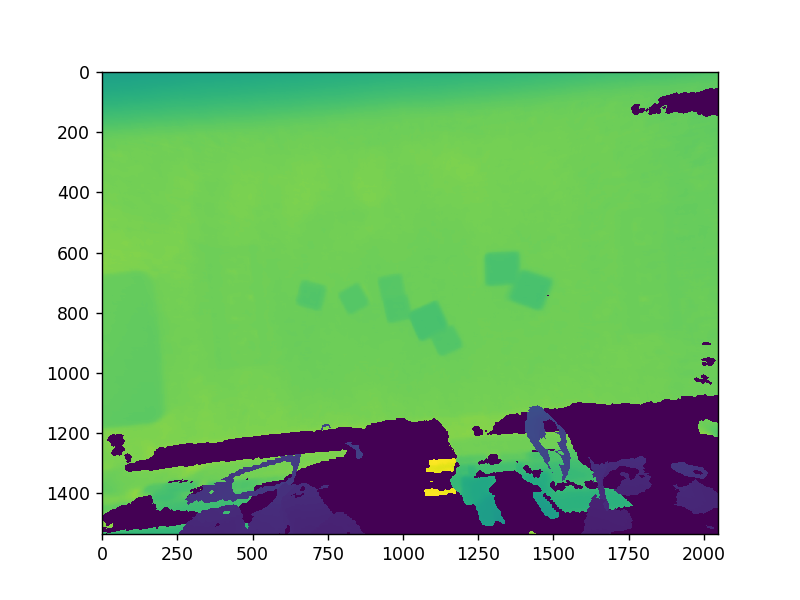

In [4]:
%matplotlib notebook
plt.figure()
plt.imshow(c.current_img)
plt.show()

In [ ]:
#----------------------------------x----y----z
image_space_coords_bottom_left = [971, 644, 519]
bl_real_space = Point()

bl_real_space.x = image_space_coords_bottom_left[0]
bl_real_space.y = image_space_coords_bottom_left[1]
bl_real_space.z = image_space_coords_bottom_left[2]
points = generate_candidate_plans(bl_real_space)

In [ ]:
new_plans = [extend_plan(plan) for plan in points]
# Filter out all plans that are none
new_plans_filtered = [plan for plan in new_plans if plan != None]

In [ ]:
def estimate_depth_cell_volume(depth, superpixels):
    '''
    Double integrate the xy values under the depth image to estimate
    the volume of the contained clutter
    '''
    plane_height = np.max(depth) - depth
    volumes = np.zeros_like(superpixels)
    for pixel in np.unique(superpixels):
        dtemp = deepcopy(plane_height)
        mask = superpixels == pixel
        dtemp[np.logical_not(mask)] = 0.00
        # Double integrate to get the volume
        volumes[mask] = np.trapz(np.trapz(dtemp,axis=0))
    return volumes

def find_intersection_cells(x, y, superpixels):
    '''
    Given a line with points x,y estimate which super pixels the line
    uniquely crosses through
    '''
    coords = np.vstack((x,y)).T
    return np.unique(superpixels[coords])

def find_tot_volume(cells: np.ndarray, superpixels: np.ndarray, volume: np.ndarray) -> float:
    '''
    Given a set of superpixel values, sum up total occupied volume
    '''
    cum_volume = 0
    for cell in cells:
        cum_volume += np.median(volume[superpixels == cell])
    return cum_volume

def swap_start(plan: np.ndarray) -> np.ndarray:
    '''
    Swap the start and end of a plan to make sure the start point is the one closest to the plane
    '''
    return (plan[1], plan[0]) if plan[1][2] > plan[0][2] else plan

def maximize_depth(plan: np.ndarray) -> np.ndarray:
    '''
    Constrain movements to the maximum z coordinate to prevent diagonal motions over the clutter
    '''
    use_depth = max(plan[0][2], plan[0][2])
    return [[*plan[0][0:2], use_depth], [*plan[1][0:2], use_depth]]

def optimize_plans(plans: np.ndarray, superpixels: np.ndarray, volumes: np.ndarray) -> np.ndarray:
    '''
    Given a number of candidate plans by measuring the volume of impacted superpixels along 
    the selected cartesian trajectory

    return: np.ndarray consisting of start/end positions of the target plan
    '''
    scores = []
    for plan in plans:
        xs = np.linspace(plan[0][0], plan[1][0], num=100, dtype=int)
        ys = np.linspace(plan[0][1], plan[1][1], num=100, dtype=int)
        cells = find_intersection_cells(xs,ys,superpixels)
        scores.append(find_tot_volume(cells, superpixels, volumes))
    print(f'Target plan selected: {np.argmax(scores)}, {plans[np.argmax(scores)]}')
    return plans[np.argmax(scores)]

In [ ]:
from cluttered_grasp.srv import superpixel
get_image = rospy.ServiceProxy("/superpixel", superpixel)
superpixels = c.br.imgmsg_to_cv2(get_image().image) # get the image in bytes format
volumes = estimate_depth_cell_volume(c.current_img, superpixels)

In [ ]:
plt.figure()
plt.imshow(volumes)

In [ ]:
optimal_plan = optimize_plans(new_plans_filtered, superpixels, volumes)
plt.figure()
plt.imshow(c.current_img)
plt.plot([optimal_plan[0][0],optimal_plan[1][0]],[optimal_plan[0][1],optimal_plan[1][1]])

In [ ]:
newplan = swap_start(optimal_plan)
print(newplan)
newplan = maximize_depth(newplan)
print(newplan)

In [ ]:
def extend_plan(plan):
    plt.figure()
    plt.imshow(c.current_img)
    STEP_SIZE = 1
    start, end = plan
    divisor = (start[0] - end[0]) or 0.1
    slope = (start[1] - end[1]) / divisor
    print(f'Slope: {slope}')
    # new values are either tuple with four elements, or none
    # four elements of tuple are x, y, z, and steps taken until safe
    new_start, new_end = extend_point(start, STEP_SIZE * -1, slope), extend_point(end, STEP_SIZE, slope)
    print(f'New Start: {new_start}')
    print(f'New End: {new_end}')
    if new_start is not None and new_end is not None:
        # Select an entry point based off of which one is closer: 
        if(new_start[3] > new_end[3]):
            return [list(new_start[:3]), end]
        else:
            return [start, list(new_end[:3])]
    
    elif new_start is not None and new_end is None:
        return [list(new_start[:3]), end]
    
    elif new_start is None and new_end is not None:
        return [start, list(new_end[:3])]
    else:
        return None

In [ ]:
def extend_point(point: List[int], step_size: int, slope: float) -> Tuple[int] or None:
    PLANE_HEIGHT = 570
    PLANE_TOL = 15 # millimeters
    BAD_TOL = 25 # number of pixels encountered that do not meet window criteria before reset
    WINDOW_TOL = 50 #number of good pixels encountered before deeming success
    Y_MIN = 100
    Y_MAX = 1100
    
    steps_taken = 0
    bad_count = 0
    
    window = []
    new_pt = point
    current_img = deepcopy(c.current_img)
    while Y_MIN <= new_pt[1] <= Y_MAX:
        new_pt = [int(point[0] + (step_size * steps_taken)), 
                  int(point[1] + (step_size * steps_taken * slope)), 
                  c.get_depth(x=int(point[0] + step_size * steps_taken),
                            y=int(point[1] + step_size * steps_taken * slope), img=current_img)]
        
        
        
        if(new_pt[2] - PLANE_TOL <= PLANE_HEIGHT <= new_pt[2] + PLANE_TOL):
            window.append(new_pt)
            plt.plot(new_pt[0], new_pt[1], 'ro', color="blue", markersize=1)
        else:
            bad_count += 1
            plt.plot(new_pt[0], new_pt[1], 'ro', color="red", markersize=1)
            
        if(bad_count >= BAD_TOL):
            window = []
            bad_count = 0
            
        elif(len(window) >= WINDOW_TOL):
            print('Criteria satisfied')
            return *new_pt, steps_taken
        
        steps_taken += 1
    plt.draw()
    return None

In [ ]:
%matplotlib notebook
plt.figure()
plt.imshow(c.current_img)
plt.show()

In [ ]:
#----------------------------------x----y----z
image_space_coords_bottom_left = [784, 593, 530]
bl_real_space = Point()

bl_real_space.x = image_space_coords_bottom_left[0]
bl_real_space.y = image_space_coords_bottom_left[1]
bl_real_space.z = image_space_coords_bottom_left[2]

In [ ]:
points = generate_candidate_plans(bl_real_space)

In [ ]:
print(points)

In [ ]:
print(points[0][0])
print(points[1][0])

start = points[0][0]
end = points[1][0]

In [ ]:
coord1 = c.convert_depth_pixel_to_metric_coordinate(pixel_x=start[0], pixel_y=start[1], depth=start[2])
coord2 = c.convert_depth_pixel_to_metric_coordinate(pixel_x=end[0], pixel_y=end[1], depth=end[2])

In [ ]:
coord = []
coord.append(coord1)
coord.append(coord2)
# print(coord)
# Need to maximize depth since that indicates furthest point to from the camera (lowest)
min_depth = max(coord[0][2], coord[-1][2])
coord[0][2] = min_depth
coord[-1][2] = min_depth
print(coord)

In [ ]:
c.execute_plan(coord)

In [ ]:
c.prep_move_arm(c.HOME)